In [ ]:
# Data Acquisition and Preprocessing

# This notebook loads raw USGS streamflow time-series data, performs quality control, and subsets all datasets to a common 6-year overlapping period for comparative analysis.

In [ ]:
# imports and paths

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("..")
RAW = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "figures"

PROC.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

raw_files = sorted(RAW.glob("*.csv"))
raw_files

[PosixPath('../data/raw/09180000_1980_2020.csv'),
 PosixPath('../data/raw/09180500_1980_2020.csv'),
 PosixPath('../data/raw/09183600_1980_2020.csv'),
 PosixPath('../data/raw/09185600_1980_2020.csv')]

In [ ]:
## Load Raw Streamflow Data 

# Each dataset is read into a Pandas DataFrame, indexed by datetime, and standardized to a single discharge column.


In [21]:
annual_totals = annual_volume.sum(axis=1)

annual_totals.sort_values()

Datetime
2014-12-31    4.321821e+10
2020-12-31    1.957363e+11
2018-12-31    2.013370e+11
2016-12-31    3.966534e+11
2015-12-31    4.094249e+11
2017-12-31    4.421275e+11
2019-12-31    5.513313e+11
dtype: float64

In [ ]:
# peek at one file to learn columns

In [4]:
fp = raw_files[0]
df0 = pd.read_csv(fp)
df0.head(), df0.columns

(     Datetime  USGS_flow    variable  USGS_ID measurement_unit     qualifiers  \
 0  1986-10-01  436.00000  streamflow  9180000            ft3/s  ['A', '[91]']   
 1  1986-10-02  416.73468  streamflow  9180000            ft3/s  ['A', '[91]']   
 2  1986-10-03  453.57144  streamflow  9180000            ft3/s  ['A', '[91]']   
 3  1986-10-04  443.57144  streamflow  9180000            ft3/s  ['A', '[91]']   
 4  1986-10-05  416.26532  streamflow  9180000            ft3/s  ['A', '[91]']   
 
    series  
 0       0  
 1       0  
 2       0  
 3       0  
 4       0  ,
 Index(['Datetime', 'USGS_flow', 'variable', 'USGS_ID', 'measurement_unit',
        'qualifiers', 'series'],
       dtype='str'))

In [ ]:
# Task 1

# loader function (robust + reusable)

In [7]:
def load_nwis_csv(fp):
    df = pd.read_csv(fp)
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.set_index("Datetime").sort_index()
    df = df[["USGS_flow"]]
    df = df.rename(columns={"USGS_flow": fp.stem.split("_")[0]})
    return df

In [ ]:
# load all 4 gages

In [8]:
dfs = [load_nwis_csv(fp) for fp in raw_files]
flow = pd.concat(dfs, axis=1)
flow.head()

,09180000,09180500,09183600,09185600
Datetime,,,,
1986-10-01,436.00000,8287.6050,NaN,NaN
1986-10-02,416.73468,8119.4790,NaN,NaN
1986-10-03,453.57144,8296.1455,NaN,NaN
1986-10-04,443.57144,9024.0625,NaN,NaN
1986-10-05,416.26532,8953.5420,NaN,NaN


In [ ]:
# inspect date ranges

In [9]:
flow.index.min(), flow.index.max()

(Timestamp('1986-10-01 00:00:00'), Timestamp('2020-09-29 00:00:00'))

In [10]:
flow.notna().sum()

09180000    10834
09180500    11439
09183600     6020
09185600     2127
dtype: int64

In [ ]:
# compute common overlap window

In [11]:
start = flow.dropna().index.min()
end = flow.dropna().index.max()

start, end

(Timestamp('2014-10-30 00:00:00'), Timestamp('2020-09-29 00:00:00'))

In [12]:
six_years = flow.loc[start:start + pd.DateOffset(years=6)]
six_years.head(), six_years.tail()

(             09180000   09180500  09183600   09185600
 Datetime                                             
 2014-10-30  206.64583  4596.2500  3.256875  4510.2780
 2014-10-31  202.87500  4583.3335  3.253958  4437.6840
 2014-11-01  199.11458  4591.3540  3.315208  4463.2290
 2014-11-02  201.04167  4598.4375  3.449583  4448.2290
 2014-11-03  203.91667  4458.9585  3.639792  4475.5293,
              09180000   09180500  09183600   09185600
 Datetime                                             
 2020-09-25  38.108334  2553.8542  2.455104  2466.7708
 2020-09-26  38.200000  2541.1458  2.410625  2431.2500
 2020-09-27  35.728127  2445.7292  2.461563  2382.1875
 2020-09-28  33.961460  2469.2708  2.467396  2233.3333
 2020-09-29  30.498924  2501.9355  2.480323  2346.0215)

In [ ]:
# Task 2

# exploratory plot

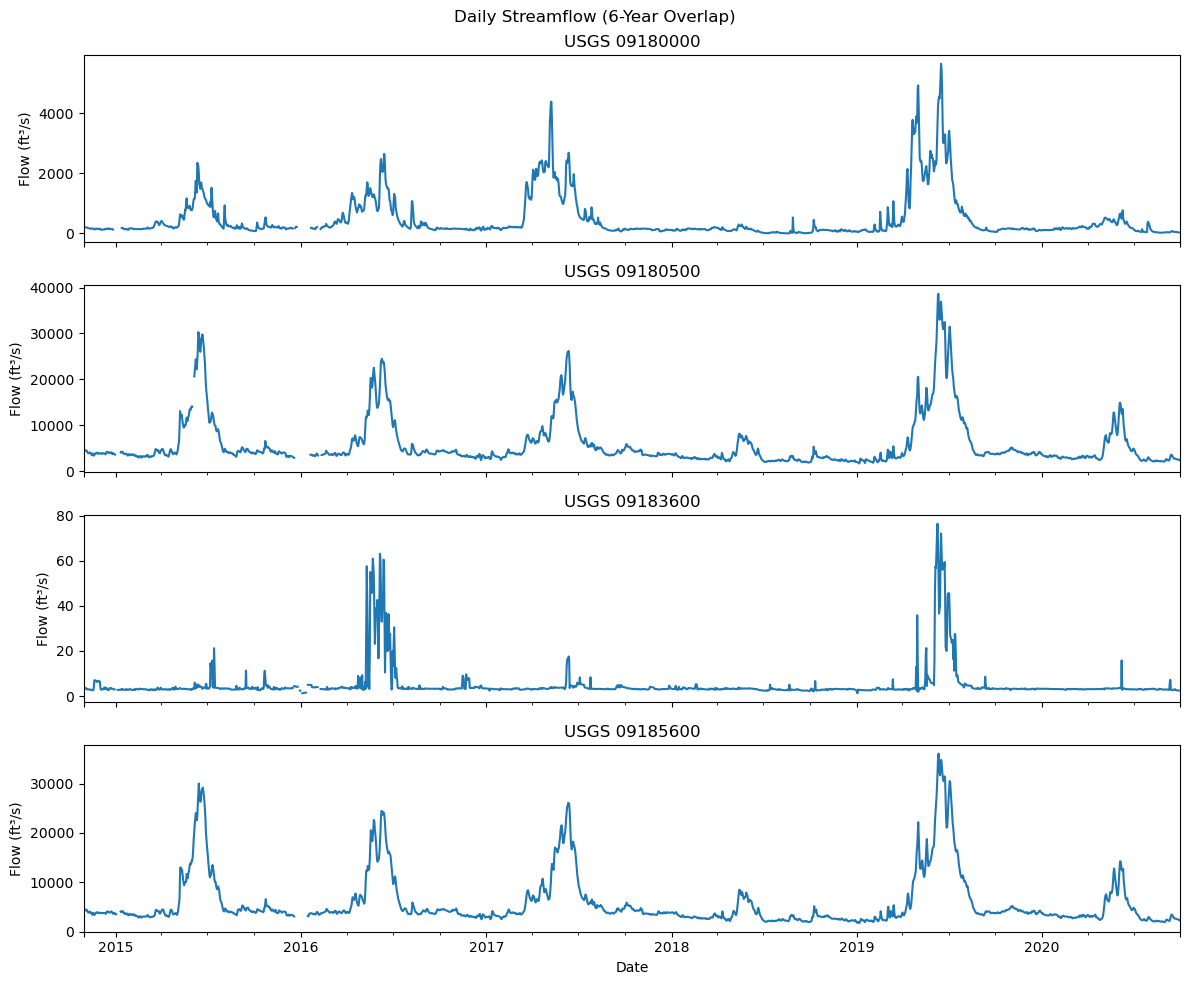

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for ax, col in zip(axes, six_years.columns):
    six_years[col].plot(ax=ax)
    ax.set_ylabel("Flow (ft³/s)")
    ax.set_title(f"USGS {col}")

axes[-1].set_xlabel("Date")
fig.suptitle("Daily Streamflow (6-Year Overlap)", y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
# Part 3

# Weekly mean (rate)

In [14]:
weekly_mean = six_years.resample("W").mean()
weekly_mean.head()

,09180000,09180500,09183600,09185600
Datetime,,,,
2014-11-02,202.419270,4592.343750,3.318906,4464.855000
2014-11-09,191.572917,4240.372029,3.108810,4176.166843
2014-11-16,160.718750,3843.601171,2.780625,3777.023800
2014-11-23,151.608633,3733.110100,5.184332,3621.398800
2014-11-30,154.921131,3942.098229,6.499762,3842.529757


In [ ]:
# Monthly volumetric total

In [16]:
# seconds per day
SECONDS_PER_DAY = 24 * 60 * 60

monthly_volume = (
    six_years
    .resample("ME")   # month-end (pandas 2.x compliant)
    .sum() * SECONDS_PER_DAY
)

# monthly_volume.head()

,09180000,09180500,09183600,09185600
Datetime,,,,
2014-10-31,3.538260e+07,7.931160e+08,5.625360e+05,7.731039e+08
2014-11-30,4.330287e+08,1.032515e+10,1.121295e+07,1.009422e+10
2014-12-31,3.373375e+08,1.052621e+10,8.447501e+06,9.880432e+09
2015-01-31,2.546055e+08,6.904808e+09,6.399684e+06,7.308272e+09
2015-02-28,3.661452e+08,8.060283e+09,7.207281e+06,7.617924e+09


In [ ]:
# Part 4

# total annual volume by year

In [18]:
annual_volume = monthly_volume.resample("YE").sum()
annual_volume

,09180000,09180500,09183600,09185600
Datetime,,,,
2014-12-31,8.057488e+08,2.164448e+10,2.022298e+07,2.074776e+10
2015-12-31,1.164935e+10,1.968579e+11,1.087791e+08,2.008088e+11
2016-12-31,1.504773e+10,1.885795e+11,2.592700e+08,1.927669e+11
2017-12-31,2.201040e+10,2.067828e+11,1.147673e+08,2.132196e+11
2018-12-31,3.211413e+09,9.891799e+10,9.575443e+07,9.911187e+10
2019-12-31,2.830363e+10,2.615908e+11,2.618059e+08,2.611751e+11
2020-12-31,4.609956e+09,9.638824e+10,7.404892e+07,9.466409e+10


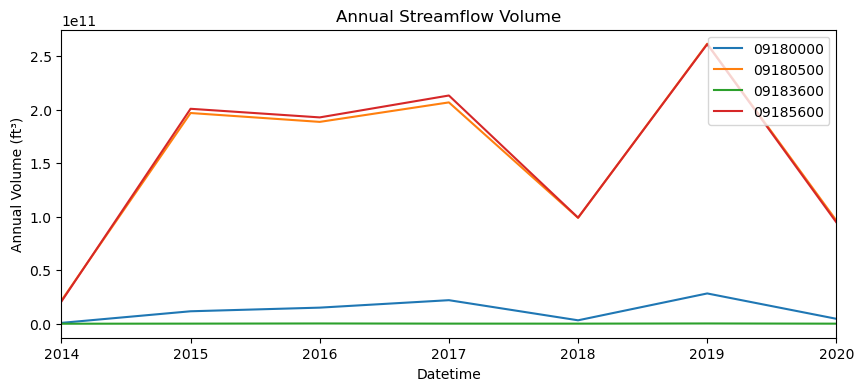

In [19]:
annual_volume.plot(figsize=(10,4), title="Annual Streamflow Volume")
plt.ylabel("Annual Volume (ft³)")
plt.show()

In [ ]:
# help to build min–max envelope

In [23]:
def daily_envelope(series):
    df = series.to_frame("q")
    df["doy"] = df.index.dayofyear
    return df.groupby("doy")["q"].agg(["min", "max"])

In [ ]:
# help to extract a specific year

In [24]:
def extract_year(series, year):
    df = series[series.index.year == year].to_frame("q")
    df["doy"] = df.index.dayofyear
    return df.groupby("doy")["q"].mean()

In [ ]:
# plot wet vs dry comparison

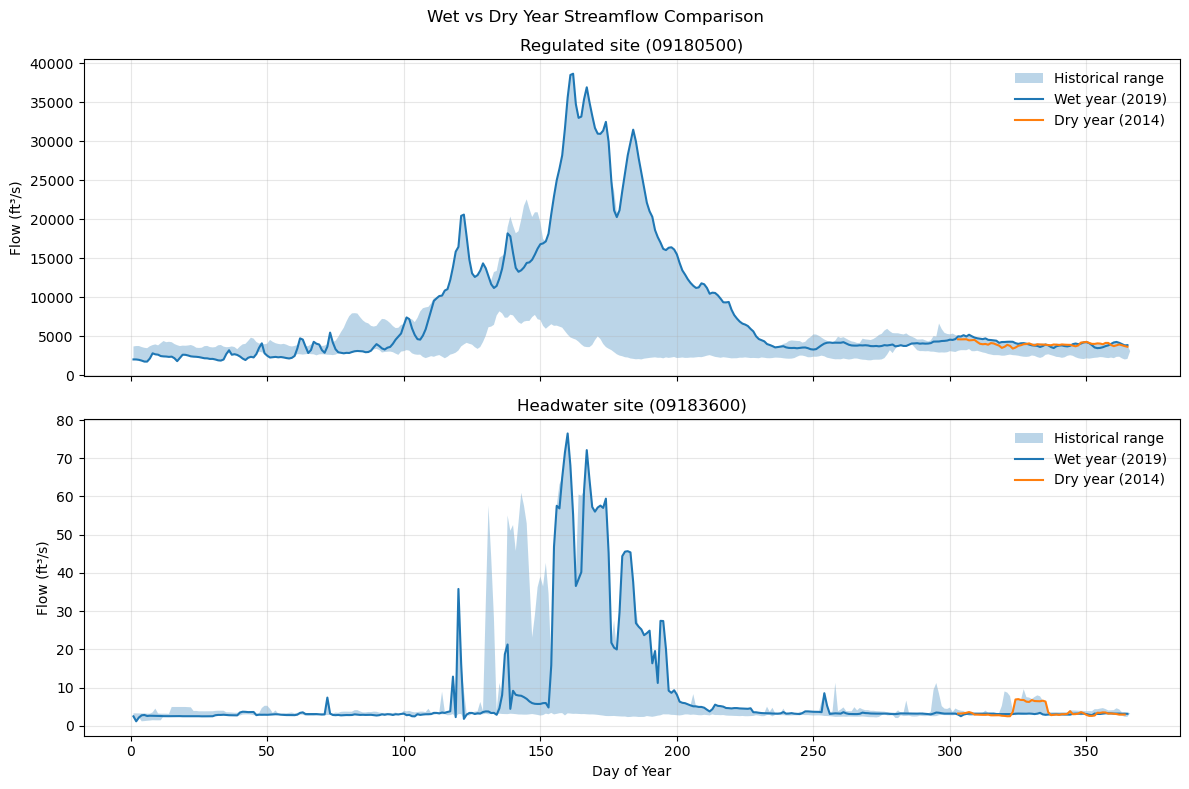

In [25]:
sites = {
    "Regulated site (09180500)": "09180500",
    "Headwater site (09183600)": "09183600",
}

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ax, (label, site) in zip(axes, sites.items()):
    env = daily_envelope(six_years[site])
    wet = extract_year(six_years[site], 2019)
    dry = extract_year(six_years[site], 2014)

    ax.fill_between(env.index, env["min"], env["max"],
                    alpha=0.3, label="Historical range")
    ax.plot(wet.index, wet.values, label="Wet year (2019)")
    ax.plot(dry.index, dry.values, label="Dry year (2014)")
    ax.set_title(label)
    ax.set_ylabel("Flow (ft³/s)")
    ax.legend(frameon=False)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Day of Year")
fig.suptitle("Wet vs Dry Year Streamflow Comparison", y=0.98)
plt.tight_layout()
plt.show()